## Identifying Duplicate Questions

In [1]:
import warnings

warnings.filterwarnings("ignore") 

In [2]:
import pandas as pd

Over 100 million people visit Quora every month, so it's no surprise that many people ask similar (or the same) questions. Various questions with the same intent can cause people to spend extra time searching for the best answer to their question, and results in members answering multiple versions of the same question. Quora uses random forest to identify duplicated questions to provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
Follow the steps outlined below to build the appropriate classifier model. 


Steps:
- Download data
- Exploration
- Cleaning
- Feature Engineering
- Modeling

By the end of this project you should have **a presentation that describes the model you built** and its **performance**. 


In [3]:
df = pd.read_csv("data/train.csv")

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


### Exploration

In [6]:
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [7]:
df[df['question1'].isnull()==True]

,id,qid1,qid2,question1,question2,is_duplicate
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [8]:
df[df['question2'].isnull()==True]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0


In [9]:
#NAs aren't helpful so dropping them
df = df.dropna()

In [10]:
#data set is unbalance about 2:1
df.is_duplicate.value_counts()

is_duplicate
0    255024
1    149263
Name: count, dtype: int64

### Cleaning

- Tokenization
- Stopwords cleaning
- Removing punctuation
- Normalizing
- Stemming

In [11]:
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Andrew\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
def unpunctuate(text):
    text = "".join([char for char in text if char not in string.punctuation])
    return text

def lowercase(text):
    text = text.lower()
    return text

def remove_stopwords(tokenized_text):
    ENGstopwords = stopwords.words('english')
    text = [word for word in tokenized_text if word not in ENGstopwords]
    return text

In [13]:
nltk.download('punkt')
from nltk.stem import PorterStemmer

ps = PorterStemmer() #will remove pre-defined stems

def stem(text):
    ps = PorterStemmer() 
    stemtext = []
    for word in text: 
        stemword = ps.stem(word)
        stemtext.append(stemword)
    return stemtext

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Andrew\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [14]:
import re

def tokenize(text):
    tokens = text.split()
    return tokens

In [15]:
def preprocess1(dataset):
    dataset['question1_cleaned'] = dataset['question1'].apply(lambda x: unpunctuate(x)) 
    dataset['question1_cleaned'] = dataset['question1_cleaned'].apply(lambda x: lowercase(x))
    
    dataset['question1_tokenized'] = dataset['question1_cleaned'].apply(lambda x: tokenize(x))
    dataset['question1_cleaned'] = dataset['question1_tokenized'].apply(lambda x: remove_stopwords(x))
    dataset = dataset.drop('question1_tokenized',axis=1)

    return dataset

def preprocess2(dataset):     
    dataset['question2_cleaned'] = dataset['question2'].apply(lambda x: unpunctuate(x)) 
    dataset['question2_cleaned'] = dataset['question2_cleaned'].apply(lambda x: lowercase(x))
    
    dataset['question2_tokenized'] = dataset['question2_cleaned'].apply(lambda x: tokenize(x))
    dataset['question2_cleaned'] = dataset['question2_tokenized'].apply(lambda x: remove_stopwords(x))
    dataset = dataset.drop('question2_tokenized',axis=1)
    
    return dataset

In [16]:
preprocess1(df)

,id,qid1,qid2,question1,question2,is_duplicate,question1_cleaned
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,"[step, step, guide, invest, share, market, india]"
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,"[story, kohinoor, kohinoor, diamond]"
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,"[increase, speed, internet, connection, using,..."
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,"[mentally, lonely, solve]"
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,"[one, dissolve, water, quikly, sugar, salt, me..."
...,...,...,...,...,...,...,...
404285,404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0,"[many, keywords, racket, programming, language..."
404286,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1,"[believe, life, death]"
404287,404287,537928,537929,What is one coin?,What's this coin?,0,"[one, coin]"
404288,404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0,"[approx, annual, cost, living, studying, uic, ..."


In [17]:
preprocess2(df)

,id,qid1,qid2,question1,question2,is_duplicate,question1_cleaned,question1_tokenized,question2_cleaned
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,"[step, step, guide, invest, share, market, india]","[what, is, the, step, by, step, guide, to, inv...","[step, step, guide, invest, share, market]"
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,"[story, kohinoor, kohinoor, diamond]","[what, is, the, story, of, kohinoor, kohinoor,...","[would, happen, indian, government, stole, koh..."
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,"[increase, speed, internet, connection, using,...","[how, can, i, increase, the, speed, of, my, in...","[internet, speed, increased, hacking, dns]"
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,"[mentally, lonely, solve]","[why, am, i, mentally, very, lonely, how, can,...","[find, remainder, math2324math, divided, 2423]"
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,"[one, dissolve, water, quikly, sugar, salt, me...","[which, one, dissolve, in, water, quikly, suga...","[fish, would, survive, salt, water]"
...,...,...,...,...,...,...,...,...,...
404285,404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0,"[many, keywords, racket, programming, language...","[how, many, keywords, are, there, in, the, rac...","[many, keywords, perl, programming, language, ..."
404286,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1,"[believe, life, death]","[do, you, believe, there, is, life, after, death]","[true, life, death]"
404287,404287,537928,537929,What is one coin?,What's this coin?,0,"[one, coin]","[what, is, one, coin]","[whats, coin]"
404288,404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0,"[approx, annual, cost, living, studying, uic, ...","[what, is, the, approx, annual, cost, of, livi...","[little, hairfall, problem, want, use, hair, s..."


In [18]:
df = df.drop(['question1','question2','question1_tokenized','question2_tokenized'],axis=1)

In [19]:
df.head()

,id,qid1,qid2,is_duplicate,question1_cleaned,question2_cleaned
0,0,1,2,0,"[step, step, guide, invest, share, market, india]","[step, step, guide, invest, share, market]"
1,1,3,4,0,"[story, kohinoor, kohinoor, diamond]","[would, happen, indian, government, stole, koh..."
2,2,5,6,0,"[increase, speed, internet, connection, using,...","[internet, speed, increased, hacking, dns]"
3,3,7,8,0,"[mentally, lonely, solve]","[find, remainder, math2324math, divided, 2423]"
4,4,9,10,0,"[one, dissolve, water, quikly, sugar, salt, me...","[fish, would, survive, salt, water]"


In [20]:
df['stem_q1'] = df['question1_cleaned'].apply(lambda x: stem(x))
df['stem_q2'] = df['question2_cleaned'].apply(lambda x: stem(x))

In [21]:
df = df.drop(['question1_cleaned','question2_cleaned'],axis=1)

### Feature Engineering

- tf-idf
- word2vec
- word count
- number of the same words in both questions
- ....

In [22]:
#Create variables for sentence length and difference in length
df['wordcount_q1'] = df['stem_q1'].apply(lambda x: len(x))
df['wordcount_q2'] = df['stem_q2'].apply(lambda x: len(x))
df['worddiff'] = abs(df['wordcount_q1'] - df['wordcount_q2'])

In [23]:
# Function to calculate the number of common words between two lists
def count_common_words(list1, list2):
    common_words = set(list1) & set(list2)
    return len(common_words)

# Create a new column with the number of common words
df['common_words_count'] = df.apply(lambda row: count_common_words(row['stem_q1'], row['stem_q2']), axis=1)


In [24]:
df.head()

,id,qid1,qid2,is_duplicate,stem_q1,stem_q2,wordcount_q1,wordcount_q2,worddiff,common_words_count
0,0,1,2,0,"[step, step, guid, invest, share, market, india]","[step, step, guid, invest, share, market]",7,6,1,5
1,1,3,4,0,"[stori, kohinoor, kohinoor, diamond]","[would, happen, indian, govern, stole, kohinoo...",4,9,5,2
2,2,5,6,0,"[increas, speed, internet, connect, use, vpn]","[internet, speed, increas, hack, dn]",6,5,1,3
3,3,7,8,0,"[mental, lone, solv]","[find, remaind, math2324math, divid, 2423]",3,5,2,0
4,4,9,10,0,"[one, dissolv, water, quikli, sugar, salt, met...","[fish, would, surviv, salt, water]",10,5,5,2


In [25]:
import numpy as np

In [26]:
#Import google word2vec 
embeddings_dict = {}
with open('data/glove.6B.100d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

In [27]:
#function to apply google vectors to words in list
def apply_word_vectors(word_list):
    vectors = [embeddings_dict[word] for word in word_list if word in embeddings_dict]
    return vectors

In [28]:
#apply word vectors to lists
df['vect_q1'] = df['stem_q1'].apply(apply_word_vectors)
df['vect_q2'] = df['stem_q2'].apply(apply_word_vectors)

In [29]:
df['wordcount_q1'] = df['wordcount_q1'].astype(np.float32)
df['wordcount_q2'] = df['wordcount_q2'].astype(np.float32)
df['worddiff'] = df['worddiff'].astype(np.float32)
df['common_words_count'] = df['common_words_count'].astype(np.float32)

In [30]:
df.head()

,id,qid1,qid2,is_duplicate,stem_q1,stem_q2,wordcount_q1,wordcount_q2,worddiff,common_words_count,vect_q1,vect_q2
0,0,1,2,0,"[step, step, guid, invest, share, market, india]","[step, step, guid, invest, share, market]",7.0,6.0,1.0,5.0,"[[0.091283, -0.13298, 0.045574, 0.57397, 0.127...","[[0.091283, -0.13298, 0.045574, 0.57397, 0.127..."
1,1,3,4,0,"[stori, kohinoor, kohinoor, diamond]","[would, happen, indian, govern, stole, kohinoo...",4.0,9.0,5.0,2.0,"[[0.67343, -0.65684, -0.73887, 0.2514, -0.0379...","[[0.039741, 0.035052, 0.32988, -0.5879, -0.250..."
2,2,5,6,0,"[increas, speed, internet, connect, use, vpn]","[internet, speed, increas, hack, dn]",6.0,5.0,1.0,3.0,"[[-0.051814, -0.36576, 0.43149, 0.26457, -0.25...","[[0.17614, 0.0020898, 0.1467, -0.40558, 0.9967..."
3,3,7,8,0,"[mental, lone, solv]","[find, remaind, math2324math, divid, 2423]",3.0,5.0,2.0,0.0,"[[0.43134, 0.30959, 0.0064551, 0.56405, -0.902...","[[-0.13778, 0.47448, 0.30845, -0.0065366, -0.3..."
4,4,9,10,0,"[one, dissolv, water, quikli, sugar, salt, met...","[fish, would, surviv, salt, water]",10.0,5.0,5.0,2.0,"[[-0.22557, 0.49418, 0.4861, -0.4332, 0.13738,...","[[-0.65654, 0.56149, 0.43801, -0.70816, -0.028..."


In [31]:
from sklearn.utils import resample

# Assuming your original dataframe is called 'df' and the target variable is 'label'

# Separate the minority and majority classes
df_minority = df[df['is_duplicate'] == 1]  # Assuming label 1 represents the minority class
df_majority = df[df['is_duplicate'] == 0]  # Assuming label 0 represents the majority class

# Undersample the majority class
df_majority_undersampled = resample(df_majority, replace=False, n_samples=len(df_minority), random_state=13)

# Combine the minority class with the undersampled majority class
df_balanced = pd.concat([df_minority, df_majority_undersampled])

# Shuffle the balanced dataframe
df_balanced = df_balanced.sample(frac=1, random_state=13).reset_index(drop=True)

### Modeling

Different modeling techniques can be used:

- logistic regression
- XGBoost
- LSTMs
- etc

In [32]:
import tensorflow as tf

In [33]:
X = df_balanced.drop(['is_duplicate','stem_q1','stem_q1','id','qid1','qid2'],axis=1)
y = df_balanced.is_duplicate

In [34]:
sentence1_vectors = X['vect_q1'].apply(np.array)
sentence2_vectors = X['vect_q2'].apply(np.array)

sentence1_average = sentence1_vectors.apply(lambda row: np.mean(row,axis=0))
sentence2_average = sentence2_vectors.apply(lambda row: np.mean(row,axis=0))

In [35]:
df2 = pd.concat([sentence1_average,sentence2_average],axis=1)

In [36]:
len(sentence1_average[0])

100

In [37]:
df2['vect_q1'][0]

array([ 0.09793834,  0.22617815,  0.20285833, -0.24670833, -0.5546232 ,
        0.28754166,  0.07366999, -0.0034725 , -0.1889103 , -0.145642  ,
       -0.1670355 , -0.29163834,  0.0375735 , -0.03838434,  0.04771936,
        0.15064333,  0.07781185,  0.04688813, -0.02064   ,  0.555955  ,
       -0.20782399,  0.48221537, -0.082307  , -0.54940337, -0.02028499,
       -0.046574  , -0.01383566, -0.44581497,  0.28294584,  0.21579534,
       -0.18337534,  0.3652067 ,  0.15471001, -0.313947  ,  0.35593152,
        0.08100001, -0.312855  ,  0.11619183,  0.07992335, -0.20678367,
        0.358385  ,  0.04199633,  0.08205383, -0.4684203 , -0.30792284,
        0.02602667, -0.14654167, -0.03927666,  0.02752933, -0.31700668,
       -0.0020345 , -0.10383867, -0.26249543,  0.34454   ,  0.1216335 ,
       -0.9451267 ,  0.02915999,  0.45595488,  0.26716167,  0.16043667,
        0.157703  ,  0.06824166, -0.33624518, -0.23815   ,  0.24551634,
        0.02795766,  0.12270167,  0.23460817, -0.35837802,  0.09

In [38]:
df2 = df2.dropna()

In [39]:
from numpy import dot
from numpy.linalg import norm

df2['cos_sim'] = np.zeros(len(df2))  # Initialize a column to store the cosine similarity values

for i in range(len(df2)):
    try:
        vec_q1 = df2['vect_q1'][i]  # Get the vector from the 'vect_q1' column for the current row
        vec_q2 = df2['vect_q2'][i]  # Get the vector from the 'vect_q2' column for the current row

        dot_product = np.dot(vec_q1, vec_q2)  # Compute the dot product of the two vectors
        norm_q1 = norm(vec_q1)  # Compute the norm of vec_q1
        norm_q2 = norm(vec_q2)  # Compute the norm of vec_q2

        cosine_similarity = dot_product / (norm_q1 * norm_q2)  # Calculate the cosine similarity

        df2['cos_sim'][i] = cosine_similarity  # Store the cosine similarity value in the 'cos_sim' column
    except:
        df2['cos_sim'][i] = 0
        
    if i%10000 == 0:
        print(i)

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000


In [40]:
df2[df2['cos_sim']==0]

,vect_q1,vect_q2,cos_sim
293343,"[-0.0142389955, -0.12144681, 0.16853161, -0.12...","[0.022896249, -0.30351752, 0.29126, 0.00200100...",0.0
293344,"[0.015876332, -0.18770666, 0.077673666, -0.444...","[0.0321265, -0.38536, 0.0909605, -0.35227498, ...",0.0
293345,"[-0.56322503, -0.544905, -0.105874, 0.16352999...","[-0.11821713, -0.054503754, 0.17856237, -0.124...",0.0
293346,"[-0.07204014, 0.220045, 0.46685, -0.13856573, ...","[-0.067460984, 0.4286275, 0.6248875, -0.50219,...",0.0
293347,"[-0.069180004, 0.29138735, 0.25406668, -0.2704...","[-0.10986251, 0.372103, 0.3729975, -0.3444275,...",0.0
...,...,...,...
298521,"[-0.18677032, -0.23759334, 0.6723433, -0.34279...","[-0.03995864, 0.19259635, 0.29144445, -0.47246...",0.0
298522,"[0.3122325, -0.03365975, -0.14127475, -0.36503...","[-0.057860233, 0.22798221, -0.050797798, -0.46...",0.0
298523,"[-0.361404, -0.323928, 0.37818998, -0.65071005...","[-0.296345, 0.59163, 0.18035151, 0.2139917, 0....",0.0
298524,"[0.33799663, 0.56696993, 0.26615998, -0.239087...","[0.19561498, 0.34992746, 0.29675248, -0.160663...",0.0


In [41]:
sentence1_average.shape

(298526,)

In [42]:
df2 = df2[df2['cos_sim']!=0]

In [43]:
X = df2.merge(X,left_index=True,right_index=True,how='left')
X = X.drop(['vect_q1_x','vect_q2_x','stem_q2','vect_q1_y','vect_q2_y'],axis=1)
X = X.merge(y, left_index=True,right_index=True,how='left')
y = X.is_duplicate

X= X.drop(['is_duplicate'],axis=1)

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2,random_state = 13)

In [45]:
# from tensorflow.keras.utils import pad_sequences

# X_train = pad_sequences(X_train, 
#                                 maxlen=100,
#                                 padding='post',
#                                 truncating='post')
# print('step1')

# X_test = pad_sequences(X_test,
#                              maxlen=100,
#                              padding='post',
#                              truncating='post')

In [46]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train,y_train)

LogisticRegression()

In [65]:
y_pred = logreg.predict(X_test)

In [48]:
from sklearn.metrics import accuracy_score, roc_auc_score

In [49]:
print(accuracy_score(y_test,y_pred))
print(roc_auc_score(y_test,y_pred))

0.6789710142413572
0.6788298922325053


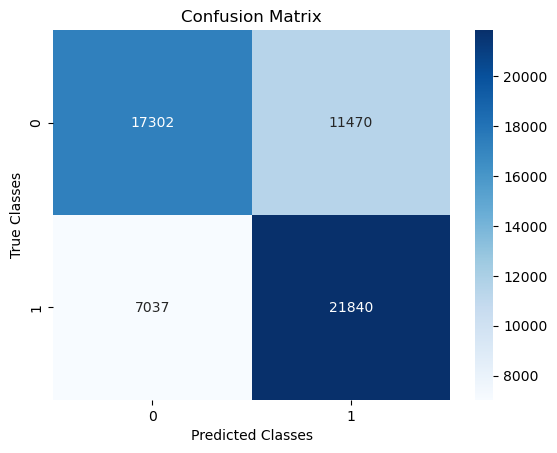

In [67]:
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Set labels, title, and axis ticks
plt.xlabel("Predicted Classes")
plt.ylabel("True Classes")
plt.title("Confusion Matrix")
plt.show()

In [50]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

In [51]:
#Code from another spot, not edited yet
# regressor = Sequential()

# regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (None,100)))
# regressor.add(Dropout(0.2))

# regressor.add(LSTM(units = 100, return_sequences = True))
# regressor.add(Dropout(0.2))

# regressor.add(LSTM(units = 50, return_sequences = True))
# regressor.add(Dropout(0.2))

# regressor.add(LSTM(units = 1))
# regressor.add(Dropout(0.2))

# regressor.add(Dense(units = 1))

# regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
# early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5)
# regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

In [90]:
X_full = X.merge(df2['vect_q1'],left_index = True, right_index = True, how = 'left')

In [91]:
X_full = X_full.merge(df2['vect_q2'],left_index = True, right_index = True, how = 'left')

In [92]:
X1 = X_full['vect_q1']
X2 = X_full['vect_q2']
X3 = X_full.drop(['vect_q1','vect_q2'],axis=1).values

# Convert the Series to numpy arrays
X1 = np.stack(X1.values)
X2 = np.stack(X2.values)

In [93]:
# Compute cosine similarity
def cosine_similarity(x):
    x1, x2 = x[0], x[1]
    x1 = K.l2_normalize(x1, axis=-1)
    x2 = K.l2_normalize(x2, axis=-1)
    return K.sum(x1 * x2, axis=-1, keepdims=True)

In [94]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

# Reshape the input arrays to match the LSTM input shape
X1 = np.reshape(X1, (X1.shape[0], X1.shape[1], 1))
X2 = np.reshape(X2, (X2.shape[0], X2.shape[1], 1))

# Define the input shape
input_shape = (X1.shape[1], 1)  # Size of the input vectors

# Define the number of LSTM units
lstm_units = 64

# Create the input layers
input1 = Input(shape=input_shape)
input2 = Input(shape=input_shape)
input_float = Input(shape=(X3.shape[1],))  # Input shape for float variables

# Shared LSTM layer
shared_lstm = LSTM(lstm_units)

# First LSTM branch
lstm1 = shared_lstm(input1)
output1 = Dense(lstm_units, activation='relu')(lstm1)

# Second LSTM branch
lstm2 = shared_lstm(input2)
output2 = Dense(lstm_units, activation='relu')(lstm2)

# Merge the outputs of the LSTM branches
merged = Concatenate()([output1, output2])

# Concatenate the float variables with the merged outputs
merged = Concatenate()([merged, input_float])

# Add additional layers if desired
merged = Dense(64, activation='relu')(merged)
merged = Dense(32, activation='relu')(merged)

# Final output layer
predictions = Dense(1, activation='sigmoid')(merged)

# Create the Siamese LSTM model
model = Model(inputs=[input1, input2, input_float], outputs=predictions)

# Compile the model
loss_fn = BinaryCrossentropy()
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

# Train the model
model.fit([X1, X2, X3], y, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
7207/7207 [==============================] - 159s 22ms/step - loss: 0.5451 - accuracy: 0.6977 - val_loss: 0.5284 - val_accuracy: 0.7110
Epoch 2/20
7207/7207 [==============================] - 156s 22ms/step - loss: 0.5286 - accuracy: 0.7136 - val_loss: 0.5203 - val_accuracy: 0.7203
Epoch 3/20
7207/7207 [==============================] - 166s 23ms/step - loss: 0.5175 - accuracy: 0.7247 - val_loss: 0.5082 - val_accuracy: 0.7324
Epoch 4/20
7207/7207 [==============================] - 164s 23ms/step - loss: 0.5078 - accuracy: 0.7327 - val_loss: 0.5032 - val_accuracy: 0.7343
Epoch 5/20
7207/7207 [==============================] - 165s 23ms/step - loss: 0.4987 - accuracy: 0.7396 - val_loss: 0.4933 - val_accuracy: 0.7418
Epoch 6/20
7207/7207 [==============================] - 170s 24ms/step - loss: 0.4913 - accuracy: 0.7446 - val_loss: 0.4876 - val_accuracy: 0.7468
Epoch 7/20
7207/7207 [==============================] - 169s 24ms/step - loss: 0.4850 - accuracy: 0.7476 - val_loss: 0

In [56]:
X1.shape

(288242, 100, 1)

In [95]:
# Obtain predictions on the validation split
X1_val_pred = X1[int(X1.shape[0] * 0.8):]  # Extract the validation split from X1
X2_val_pred = X2[int(X2.shape[0] * 0.8):]  # Extract the validation split from X2
X3_val_pred = X3[int(X3.shape[0] * 0.8):]  # Extract the validation split from X3

y_pred = model.predict([X1_val_pred, X2_val_pred, X3_val_pred])

1802/1802 [==============================] - 14s 8ms/step


In [96]:
y_pred_c = (y_pred > .5).astype(int)

In [97]:
y_test = y[int(y.shape[0] * 0.8):]

In [98]:
print(accuracy_score(y_test,y_pred_c))
print(roc_auc_score(y_test,y_pred_c))

0.7635865322902392
0.7633654374684601


In [99]:
from sklearn.metrics import confusion_matrix

# Assuming y_true contains the true labels and y_pred_classes contains the predicted classes

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred_c)

print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[20652  8025]
 [ 5604 23368]]


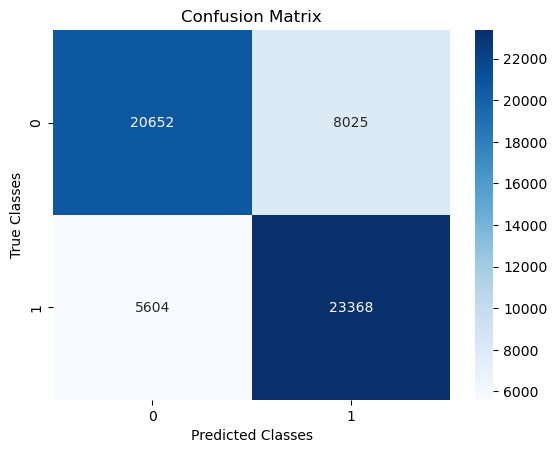

In [100]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Set labels, title, and axis ticks
plt.xlabel("Predicted Classes")
plt.ylabel("True Classes")
plt.title("Confusion Matrix")
plt.show()